# ORF recognition by CNN

In 105, we used Conv1D layers with filter width=3 with dropout to reduce overfitting. The simulated RNA lengths were 1000.

Use really short simulated RNA where all of it is generated by the same Transcript generator. Thus, all of it has an ORF initially. Then make a one-base indel to every sequence. To the pcRNA, add a random new or last base to each sequence, so the ORF is still intact. To the ncRNA, insert a random base to the center and randomly remove the first or last base, so the ORF has been disrupted. Confirm with our max ORF len counter. The result indicates that the CNN can classify based on framshifts.

In [1]:
import time 
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-10 15:01:05 EDT'

In [2]:
PC_SEQUENCES=2000   # how many protein-coding sequences
NC_SEQUENCES=2000   # how many non-coding sequences
PC_TESTS=1000
NC_TESTS=1000
RNA_LEN=21            # how long is each sequence
CDS_LEN=15
ALPHABET=4          # how many different letters are possible
INPUT_SHAPE_2D = (RNA_LEN,ALPHABET,1) # Conv2D needs 3D inputs
INPUT_SHAPE = (RNA_LEN,ALPHABET) # Conv1D needs 2D inputs
FILTERS = 16   # how many different patterns the model looks for
NEURONS = 16
DROP_RATE = 0.2
WIDTH = 3   # how wide each pattern is, in bases
STRIDE_2D = (1,1)  # For Conv2D how far in each direction
STRIDE = 1 # For Conv1D, how far between pattern matches, in bases
EPOCHS=20  # how many times to train on all the data
SPLITS=5  # SPLITS=3 means train on 2/3 and validate on 1/3 
FOLDS=2  # train the model this many times (range 1 to SPLITS)

In [3]:
import sys
try:
    from google.colab import drive
    IN_COLAB = True
    print("On Google CoLab, mount cloud-local file, get our code from GitHub.")
    PATH='/content/drive/'
    #drive.mount(PATH,force_remount=True)  # hardly ever need this
    #drive.mount(PATH)    # Google will require login credentials
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_gen.py')
    with open('RNA_gen.py', 'w') as f:
        f.write(r.text)  
    from RNA_gen import *
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_describe.py')
    with open('RNA_describe.py', 'w') as f:
        f.write(r.text)  
    from RNA_describe import ORF_counter
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/Soars2021/master/SimTools/RNA_prep.py')
    with open('RNA_prep.py', 'w') as f:
        f.write(r.text)  
    from RNA_prep import *
except:
    print("CoLab not working. On my PC, use relative paths.")
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
    sys.path.append("..") # append parent dir in order to use sibling dirs
    from SimTools.RNA_gen import *
    from SimTools.RNA_describe import ORF_counter
    from SimTools.RNA_prep import *

MODELPATH="BestModel"  # saved on cloud instance and lost after logout
#MODELPATH=DATAPATH+MODELPATH  # saved on Google Drive but requires login

if not assert_imported_RNA_gen():
    print("ERROR: Cannot use RNA_gen.")
if not assert_imported_RNA_prep():
    print("ERROR: Cannot use RNA_prep.")

CoLab not working. On my PC, use relative paths.


In [4]:
from os import listdir
import csv
from zipfile import ZipFile

import numpy as np
import pandas as pd
from scipy import stats  # mode

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from keras.models import Sequential
from keras.layers import Dense,Embedding,Dropout
from keras.layers import Conv1D,Conv2D
from keras.layers import Flatten,MaxPooling1D,MaxPooling2D
from keras.losses import BinaryCrossentropy
# tf.keras.losses.BinaryCrossentropy

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)


In [5]:
# Use code from our SimTools library.
def make_generators(seq_len):
    pcgen = Collection_Generator()  
    pcgen.get_len_oracle().set_mean(seq_len)
    tora = Transcript_Oracle()
    tora.set_cds_len_mean(CDS_LEN)  # CDS=ORF+STOP. Method is misnamed.
    pcgen.set_seq_oracle(tora)
    ncgen = Collection_Generator()  
    ncgen.get_len_oracle().set_mean(seq_len)
    return pcgen,ncgen

pc_sim,nc_sim = make_generators(RNA_LEN)
pc_all = pc_sim.get_sequences(PC_SEQUENCES+PC_TESTS)
nc_all = pc_sim.get_sequences(NC_SEQUENCES+NC_TESTS) # YES, pc_sim!
print("Use",len(pc_all),"PC seqs")
print("Use",len(nc_all),"NC seqs")

Use 3000 PC seqs
Use 3000 NC seqs


In [6]:
# Describe the sequences
def describe_sequences(list_of_seq):
    oc = ORF_counter()
    num_seq = len(list_of_seq)
    rna_lens = np.zeros(num_seq)
    orf_lens = np.zeros(num_seq)
    for i in range(0,num_seq):
        rna_len = len(list_of_seq[i])
        rna_lens[i] = rna_len
        oc.set_sequence(list_of_seq[i])
        orf_len = oc.get_max_orf_len()
        orf_lens[i] = orf_len
    print ("Average RNA length:",rna_lens.mean())
    print ("Average ORF length:",orf_lens.mean())
    
print("PC seqs")
describe_sequences(pc_all)
print("NC seqs")
describe_sequences(nc_all)

PC seqs
Average RNA length: 21.0
Average ORF length: 10.999
NC seqs
Average RNA length: 21.0
Average ORF length: 11.044


In [7]:
import random
def alter_sequences(list_of_seq,center):
    global next_pos,bases
    new_list = []
    for S in list_of_seq:
        seq_len = len(S)
        next_left = random.choice([True,False])
        next_base = random.choice(['A','C','G','T'])
        new_seq=""
        if center:
            half=seq_len//2
            if next_left:
                new_seq=S[0:half]+next_base+S[half:-1]
            else:
                new_seq=S[1:half]+next_base+S[half:]
        else:
            if next_left:
                new_seq=next_base+S[1:]
            else:
                new_seq=S[:-1]+next_base 
        new_list.append(new_seq)
    return new_list
pc_all = alter_sequences(pc_all,False)
nc_all = alter_sequences(nc_all,True)

print("PC train")
describe_sequences(pc_all)
print("NC train")
describe_sequences(nc_all)

PC train
Average RNA length: 21.0
Average ORF length: 10.841
NC train
Average RNA length: 21.0
Average ORF length: 0.98


In [8]:
pc_train=pc_all[:PC_SEQUENCES]
nc_train=nc_all[:NC_SEQUENCES]
pc_test=pc_all[PC_SEQUENCES:]
nc_test=nc_all[NC_SEQUENCES:]

In [9]:
# Use code from our SimTools library.
X,y = prepare_inputs_len_x_alphabet(pc_train,nc_train,ALPHABET) # shuffles
print("Data ready.")

Data ready.


In [10]:
def make_DNN():
    print("make_DNN")
    print("input shape:",INPUT_SHAPE)
    dnn = Sequential()
    #dnn.add(Embedding(input_dim=INPUT_SHAPE,output_dim=INPUT_SHAPE)) 
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same",
            input_shape=INPUT_SHAPE))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(Conv1D(filters=FILTERS,kernel_size=WIDTH,strides=STRIDE,padding="same"))
    dnn.add(MaxPooling1D())
    dnn.add(Flatten())
    dnn.add(Dense(NEURONS,activation="sigmoid",dtype=np.float32))   
    dnn.add(Dropout(DROP_RATE))
    dnn.add(Dense(1,activation="sigmoid",dtype=np.float32))   
    dnn.compile(optimizer='adam',
                loss=BinaryCrossentropy(from_logits=False),
                metrics=['accuracy'])   # add to default metrics=loss
    dnn.build(input_shape=INPUT_SHAPE)
    #ln_rate = tf.keras.optimizers.Adam(learning_rate = LN_RATE)
    #bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    #model.compile(loss=bc, optimizer=ln_rate, metrics=["accuracy"])
    return dnn
model = make_DNN()
print(model.summary())

make_DNN
input shape: (21, 4)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 21, 16)            208       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 21, 16)            784       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 16)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 10, 16)            784       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 10, 16)            784       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
flatten (Flatten)         

In [11]:
from keras.callbacks import ModelCheckpoint
def do_cross_validation(X,y):
    cv_scores = []
    fold=0
    mycallbacks = [ModelCheckpoint(
        filepath=MODELPATH, save_best_only=True, 
        monitor='val_accuracy', mode='max')]   
    splitter = KFold(n_splits=SPLITS)  # this does not shuffle
    for train_index,valid_index in splitter.split(X):
        if fold < FOLDS:
            fold += 1
            X_train=X[train_index] # inputs for training
            y_train=y[train_index] # labels for training
            X_valid=X[valid_index] # inputs for validation
            y_valid=y[valid_index] # labels for validation
            print("MODEL")
            # Call constructor on each CV. Else, continually improves the same model.
            model = model = make_DNN()
            print("FIT")  # model.fit() implements learning
            start_time=time.time()
            history=model.fit(X_train, y_train, 
                    epochs=EPOCHS, 
                    verbose=1,  # ascii art while learning
                    callbacks=mycallbacks,   # called at end of each epoch
                    validation_data=(X_valid,y_valid))
            end_time=time.time()
            elapsed_time=(end_time-start_time)                        
            print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
            # print(history.history.keys())  # all these keys will be shown in figure
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1) # any losses > 1 will be off the scale
            plt.show()


MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/20
100/100 [==============================] - 4s 24ms/step - loss: 0.7323 - accuracy: 0.5261 - val_loss: 0.6621 - val_accuracy: 0.6700
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 2/20
100/100 [==============================] - 1s 11ms/step - loss: 0.6302 - accuracy: 0.6556 - val_loss: 0.5094 - val_accuracy: 0.7550
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 3/20
100/100 [==============================] - 1s 14ms/step - loss: 0.4286 - accuracy: 0.8420 - val_loss: 0.3602 - val_accuracy: 0.8712
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 4/20
100/100 [==============================] - 1s 14ms/step - loss: 0.2874 - accuracy: 0.9080 - val_loss: 0.2845 - val_accuracy: 0.9050
INFO:tensorflow:Assets written to: BestModel/assets
Epoch 5/20
100/100 [==============================] - 2s 17ms/step - loss: 0.2429 - accuracy: 0.9270 - val_loss: 0.2474 - val_accuracy: 0.9225
INFO:tensorflow:Assets written to: Be

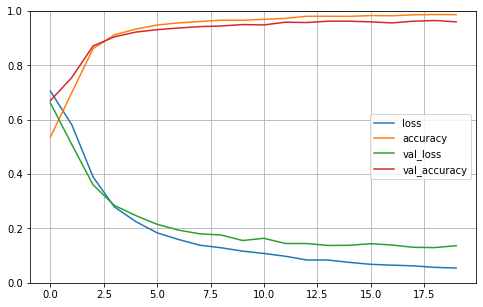

MODEL
make_DNN
input shape: (21, 4)
FIT
Epoch 1/20
100/100 [==============================] - 10s 28ms/step - loss: 0.7236 - accuracy: 0.4699 - val_loss: 0.6762 - val_accuracy: 0.6000
Epoch 2/20
100/100 [==============================] - 1s 13ms/step - loss: 0.6623 - accuracy: 0.5987 - val_loss: 0.5734 - val_accuracy: 0.7225
Epoch 3/20
100/100 [==============================] - 1s 11ms/step - loss: 0.5177 - accuracy: 0.7562 - val_loss: 0.3535 - val_accuracy: 0.8775
Epoch 4/20
100/100 [==============================] - 1s 10ms/step - loss: 0.3278 - accuracy: 0.8887 - val_loss: 0.2366 - val_accuracy: 0.9350
Epoch 5/20
100/100 [==============================] - 1s 10ms/step - loss: 0.2294 - accuracy: 0.9319 - val_loss: 0.1889 - val_accuracy: 0.9400
Epoch 6/20
100/100 [==============================] - 1s 13ms/step - loss: 0.1833 - accuracy: 0.9418 - val_loss: 0.1484 - val_accuracy: 0.9588
Epoch 7/20
100/100 [==============================] - 1s 9ms/step - loss: 0.1435 - accuracy: 0.9634 -

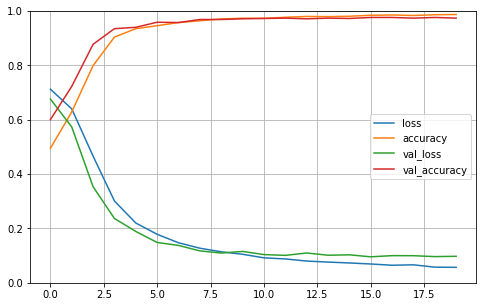

In [12]:
do_cross_validation(X,y)

In [13]:
from keras.models import load_model
#pc_sim.set_reproducible(True)
#nc_sim.set_reproducible(True)
#pc_test = pc_sim.get_sequences(PC_TESTS)
#nc_test = nc_sim.get_sequences(NC_TESTS)
X,y = prepare_inputs_len_x_alphabet(pc_test,nc_test,ALPHABET)
best_model=load_model(MODELPATH)
scores = best_model.evaluate(X, y, verbose=0)
print("The best model parameters were saved during cross-validation.")
print("Best was defined as maximum validation accuracy at end of any epoch.")
print("Now re-load the best model and test it on previously unseen data.")
print("Test on",len(pc_test),"PC seqs")
print("Test on",len(nc_test),"NC seqs")
print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))


The best model parameters were saved during cross-validation.
Best was defined as maximum validation accuracy at end of any epoch.
Now re-load the best model and test it on previously unseen data.
Test on 1000 PC seqs
Test on 1000 NC seqs
accuracy: 97.10%


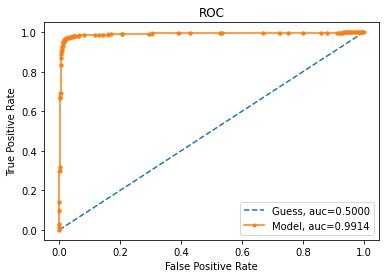

AUC: 99.14%


In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
ns_probs = [0 for _ in range(len(y))]
bm_probs = best_model.predict(X)
ns_auc = roc_auc_score(y, ns_probs)
bm_auc = roc_auc_score(y, bm_probs)
ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
bm_fpr, bm_tpr, _ = roc_curve(y, bm_probs)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Guess, auc=%.4f'%ns_auc)
plt.plot(bm_fpr, bm_tpr, marker='.', label='Model, auc=%.4f'%bm_auc)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
print("%s: %.2f%%" %('AUC',bm_auc*100.0))


In [15]:
t = time.time()
time.strftime('%Y-%m-%d %H:%M:%S %Z', time.localtime(t))

'2021-06-10 15:03:48 EDT'

## Conclusion
The CNN is very capable of learning ORF/nonORF where the only difference is a frameshift indel to an ORF in order to create the nonORF.